In [1]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


# Imports and configs

In [2]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"

    target = "label"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
cols_to_drop = [
    'X100', 'X101', 'X102', 'X104', 'X110', 'X114', 'X116', 'X122', 'X128', 'X134',
    'X140', 'X143', 'X146', 'X152', 'X158', 'X164', 'X170', 'X176', 'X182', 'X237',
    'X240', 'X242', 'X244', 'X246', 'X266', 'X306', 'X308', 'X309', 'X327', 'X348',
    'X351', 'X357', 'X363', 'X369', 'X375', 'X381', 'X387', 'X392', 'X393', 'X394',
    'X399', 'X405', 'X411', 'X417', 'X423', 'X429', 'X481', 'X484', 'X486', 'X492',
    'X501', 'X508', 'X515', 'X519', 'X521', 'X522', 'X528', 'X529', 'X533', 'X534', 
    'X535', 'X536', 'X541', 'X542', 'X543', 'X544', 'X550', 'X563', 'X569', 'X570', 
    'X571', 'X576', 'X577', 'X578', 'X582', 'X585', 'X590', 'X591', 'X593', 'X597', 
    'X61', 'X615', 'X616', 'X618', 'X62', 'X621', 'X622', 'X624', 'X625', 'X627', 
    'X628', 'X630', 'X633', 'X642', 'X648', 'X670', 'X68', 'X697', 'X698', 'X699',
    'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709',
    'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X739', 'X74',
    'X740', 'X749', 'X767', 'X775', 'X80', 'X807', 'X811', 'X815', 'X848', 'X850',
    'X864', 'X867', 'X869', 'X870', 'X871', 'X872'
]

In [6]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=["label"] + cols_to_drop)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

Reducing memory usage for: train
--- Memory usage before: 3049.27 MB
--- Memory usage after: 762.32 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 3116.27 MB
--- Memory usage after: 779.07 MB
--- Decreased memory usage by 75.0%



# Training base models

In [7]:
class Trainer:
    def __init__(self, model):
        self.model = model

    def fit_predict(self, X, y, X_test):
        print(f"Training {self.model.__class__.__name__}\n")

        fold_scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])

        split = KFold(n_splits=CFG.n_folds, shuffle=False).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):

            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_preds = model.predict(X_val)
            oof_preds[val_idx] = y_preds
            
            temp_test_preds = model.predict(X_test)
            test_preds += temp_test_preds / CFG.n_folds

            fold_score = pearsonr(y_val, y_preds)[0]
            fold_scores.append(fold_score)

            print(f"--- Fold {fold_idx} - Score: {fold_score:.6f}")

            del X_train, y_train, X_val, y_val, y_preds, model, temp_test_preds
            gc.collect()

        overall_score = pearsonr(y, oof_preds)[0]
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        
        print(f"\n------ Overall Score: {overall_score:.6f} - Mean Score: {mean_score:.6f} ± {std_score:.6f}")
        
        return oof_preds, test_preds, fold_scores
    
    def tune(self, X, y):
        fold_scores = []
        
        split = KFold(n_splits=CFG.n_folds, shuffle=False).split(X, y)
        for train_idx, val_idx in split:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_preds = model.predict(X_val)
            fold_score = pearsonr(y_val, y_preds)[0]
            fold_scores.append(fold_score)

            del X_train, y_train, X_val, y_val, y_preds, model
            gc.collect()

        return np.mean(fold_scores)

In [8]:
lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5242042724303907,
    "learning_rate": 0.014470794293130388,
    "min_child_samples": 47,
    "min_child_weight": 0.1936457311991661,
    "n_estimators": 441,
    "n_jobs": -1,
    "num_leaves": 65,
    "random_state": 42,
    "reg_alpha": 76.69015407123774,
    "reg_lambda": 78.57981723239948,
    "subsample": 0.35497610282716086,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.32266516869045214,
    "learning_rate": 0.013684657681610528,
    "min_child_samples": 47,
    "min_child_weight": 0.652800548618323,
    "n_estimators": 268,
    "n_jobs": -1,
    "num_leaves": 25,
    "random_state": 42,
    "reg_alpha": 24.43093150663448,
    "reg_lambda": 39.81794248056326,
    "subsample": 0.21026644887863555,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.4634967322919854,
    "colsample_bynode": 0.6046331585629835,
    "colsample_bytree": 0.11495541333509408,
    "gamma": 1.0397769239502863,
    "learning_rate": 0.09622196913585954,
    "max_depth": 40,
    "max_leaves": 19,
    "min_child_weight": 76,
    "n_estimators": 679,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 65.41659225037377,
    "reg_lambda": 19.907991015311545,
    "subsample": 0.014465324175810368,
    "verbosity": 0
}

In [9]:
scores = {}
oof_preds = {}
test_preds = {}

## LightGBM (gbdt)

In [10]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params)
)

oof_preds["LightGBM (gbdt)"], test_preds["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test)

Training LGBMRegressor

--- Fold 0 - Score: 0.172488
--- Fold 1 - Score: 0.109681
--- Fold 2 - Score: 0.050589
--- Fold 3 - Score: 0.130357
--- Fold 4 - Score: 0.058332

------ Overall Score: 0.093186 - Mean Score: 0.104289 ± 0.045509


## LightGBM (goss)

In [11]:
lgbm_goss_trainer = Trainer(LGBMRegressor(**lgbm_goss_params))

oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"] = lgbm_goss_trainer.fit_predict(X, y, X_test)

Training LGBMRegressor

--- Fold 0 - Score: 0.146376
--- Fold 1 - Score: 0.119751
--- Fold 2 - Score: 0.031450
--- Fold 3 - Score: 0.168844
--- Fold 4 - Score: 0.092273

------ Overall Score: 0.099619 - Mean Score: 0.111739 ± 0.047645


## XGBoost

In [12]:
xgb_trainer = Trainer(XGBRegressor(**xgb_params))

oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test)

Training XGBRegressor

--- Fold 0 - Score: 0.160088
--- Fold 1 - Score: 0.099577
--- Fold 2 - Score: 0.062908
--- Fold 3 - Score: 0.114334
--- Fold 4 - Score: 0.067314

------ Overall Score: 0.101674 - Mean Score: 0.100844 ± 0.035375


# Ensembling with Ridge

In [13]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [14]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 1000),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "positive": trial.suggest_categorical("positive", [True, False])
    }
    
    trainer = Trainer(Ridge(**params))
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"],
        "fit_intercept": best_params["fit_intercept"],
        "positive": best_params["positive"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-25 09:47:12,224] A new study created in memory with name: no-name-6f6e08af-6cdd-406f-959d-63ab0d078bb8
[I 2025-05-25 09:47:15,398] Trial 0 finished with value: 0.11656197547150256 and parameters: {'alpha': 23.71369563967962, 'tol': 0.006121056445453266, 'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 0.11656197547150256.
[I 2025-05-25 09:47:15,685] Trial 2 finished with value: 0.11942823198808272 and parameters: {'alpha': 932.9933800044328, 'tol': 0.005386692160450691, 'fit_intercept': False, 'positive': True}. Best is trial 2 with value: 0.11942823198808272.
[I 2025-05-25 09:47:15,826] Trial 3 finished with value: 0.11942437271660156 and parameters: {'alpha': 185.86331866797212, 'tol': 0.004061120448567382, 'fit_intercept': False, 'positive': True}. Best is trial 2 with value: 0.11942823198808272.
[I 2025-05-25 09:47:15,962] Trial 1 finished with value: 0.11938843346996326 and parameters: {'alpha': 793.1684546621376, 'tol': 0.0017170007154403172, 'fit

In [15]:
ridge_trainer = Trainer(Ridge(**ridge_params))

_, ridge_test_preds, scores["Ridge (ensemble)"] = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 0 - Score: 0.191853
--- Fold 1 - Score: 0.123223
--- Fold 2 - Score: 0.059543
--- Fold 3 - Score: 0.148057
--- Fold 4 - Score: 0.075135

------ Overall Score: 0.101931 - Mean Score: 0.119562 ± 0.048223


# Submission

In [16]:
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,ID,prediction
0,1,0.083148
1,2,0.012085
2,3,0.047164
3,4,-0.051744
4,5,0.165294


# Results

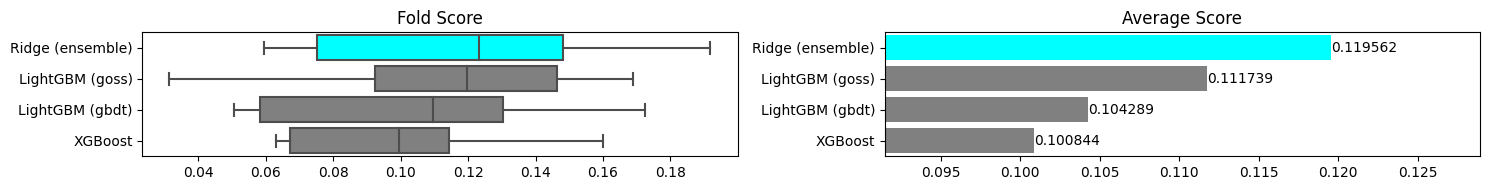

In [17]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.5))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()